# BPS5231 AI For Sustainable Building Design - L2

# 🧰 Intro to scikit-learn (Logistic Regression)

**Today’s workflow**
1. Get data ready (features/target)
2. Pick a model (start simple)
3. Fit model to training data
4. Make predictions on test data
5. Evaluate model performance
6. Improve via experimentation (hyperparameters / alternative models)
7. Save & reload the trained model

**Context:** Predict **Overheating (Yes/No)** for buildings from design and climate features.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

import joblib

plt.rcParams.update({
    "figure.figsize": (6.5, 5),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 12,
})
np.random.seed(42)

In [ ]:
# Synthetic dataset for overheating prediction
n = 800
rng = np.random.default_rng(42)

X_df = pd.DataFrame({
    "WWR": rng.uniform(10, 80, n),                     # Window-to-Wall Ratio (%)
    "SHGC": rng.uniform(0.2, 0.6, n),                  # Glazing Solar Heat Gain Coef
    "Orientation": rng.choice(["N","E","S","W"], n),   # Primary facade orientation
    "FloorArea": rng.uniform(200, 5000, n),            # m²
    "OccDensity": rng.uniform(0.05, 0.3, n),           # people per m²
    "OutdoorTemp": rng.normal(30, 4, n),               # °C
    "ShadingDepth": rng.uniform(0.0, 1.5, n),          # m
})

# True probability of overheating
z = (
    + 0.05*(X_df["WWR"] - 45)
    + 2.0*(X_df["SHGC"] - 0.35)
    + 0.03*(X_df["OutdoorTemp"] - 30)
    + 2.5*(X_df["OccDensity"] - 0.15)
    - 0.6*(X_df["ShadingDepth"] - 0.5)
    + X_df["Orientation"].map({"N":-0.15, "E":0.1, "S":0.2, "W":0.0}).values
)
prob = 1 / (1 + np.exp(-z))
y = (rng.random(n) < prob).astype(int)

data = X_df.copy()
data["Overheating"] = y

display(data.head())
print("Overheating rate:", data["Overheating"].mean().round(3))

,WWR,SHGC,Orientation,FloorArea,OccDensity,OutdoorTemp,ShadingDepth,Overheating
0,64.176923,0.495432,W,4245.113450,0.299557,31.785844,0.457433,1
1,40.721491,0.326861,W,2342.669562,0.173116,29.759631,0.270467,0
2,70.101854,0.556008,W,4774.280775,0.065326,30.050314,0.920391,1
3,58.815762,0.437532,N,3323.814031,0.198964,32.627274,0.342655,1
4,16.592414,0.250411,E,756.314554,0.079756,27.090529,0.888311,0


Overheating rate: 0.489


In [ ]:
X = data.drop(columns=["Overheating"])
y = data["Overheating"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)

(600, 7) (200, 7)


In [ ]:
# Preprocess features manually
cat = pd.get_dummies(X_train["Orientation"], prefix="Orient")
num = X_train.drop(columns=["Orientation"])
X_train_proc = pd.concat([num, cat], axis=1)

cat_test = pd.get_dummies(X_test["Orientation"], prefix="Orient")
num_test = X_test.drop(columns=["Orientation"])
X_test_proc = pd.concat([num_test, cat_test], axis=1)

# Align columns between train/test
X_test_proc = X_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)

# Standardize numeric features
scaler = StandardScaler()
X_train_proc[X_train_proc.columns] = scaler.fit_transform(X_train_proc)
X_test_proc[X_test_proc.columns] = scaler.transform(X_test_proc)

In [ ]:
# A toy 2D example (not building data), to show how logistic regression separates classes
from sklearn.datasets import make_classification

X_vis, y_vis = make_classification(
    n_samples=300, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, class_sep=1.2, random_state=42
)

model_vis = LogisticRegression()
model_vis.fit(X_vis, y_vis)

LogisticRegression()

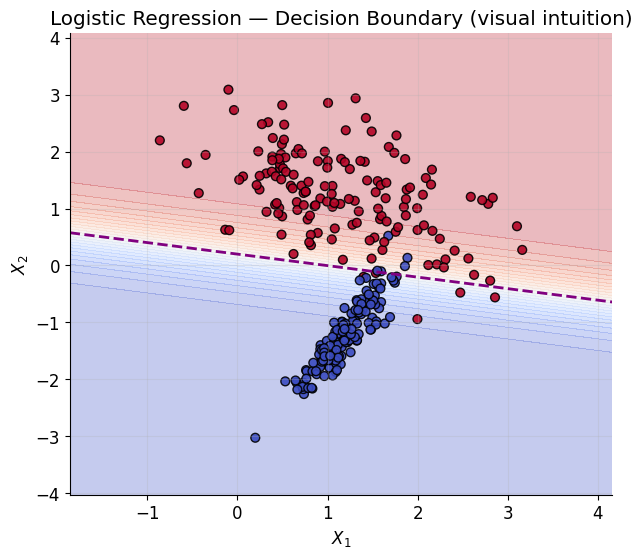

In [ ]:
xx, yy = np.meshgrid(
    np.linspace(X_vis[:,0].min()-1, X_vis[:,0].max()+1, 300),
    np.linspace(X_vis[:,1].min()-1, X_vis[:,1].max()+1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model_vis.predict_proba(grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, probs, levels=25, alpha=0.3, cmap="coolwarm")
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_vis, cmap="coolwarm", edgecolor="k", s=40, alpha=0.9)
plt.contour(xx, yy, probs, levels=[0.5], colors="purple", linestyles="--", linewidths=2)
plt.xlabel("$X_1$"); plt.ylabel("$X_2$")
plt.title("Logistic Regression — Decision Boundary (visual intuition)")
plt.show()

In [ ]:
# TODO: Fit a logistic regression model on building dataset
model = LogisticRegression(max_iter=500)

# 👉 STUDENTS: fill in this line
# 👉## FILL ME ##👈

# Uncomment to test after filling
print("Fitted coefficients:", model.coef_)

Fitted coefficients: [[ 1.13362350e+00  2.95162068e-01  2.12105215e-02  2.11237197e-01
   9.95159162e-02 -2.29875101e-01  3.61529332e-02 -6.68796861e-02
   8.25858049e-04  3.43347866e-02]]


Accuracy: 0.69
ROC AUC: 0.7590036014405762

Classification report:
               precision    recall  f1-score   support

           0      0.682     0.735     0.708       102
           1      0.700     0.643     0.670        98

    accuracy                          0.690       200
   macro avg      0.691     0.689     0.689       200
weighted avg      0.691     0.690     0.689       200



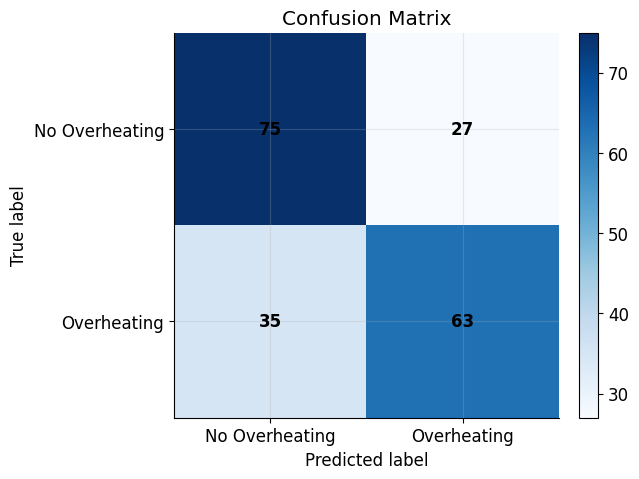

In [ ]:
y_pred = model.predict(X_test_proc)
y_prob = model.predict_proba(X_test_proc)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")  # ✅ use lighter colormap so text is visible
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["No Overheating","Overheating"])
ax.set_yticklabels(["No Overheating","Overheating"])

# annotate counts in cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="black", fontsize=12, fontweight="bold")

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

# --- Interpretation Guide ---
# Top-left (TN): Correctly predicted "No Overheating"
# Top-right (FP): Predicted "Overheating" but actually "No"
# Bottom-left (FN): Predicted "No" but actually "Overheating"
# Bottom-right (TP): Correctly predicted "Overheating"

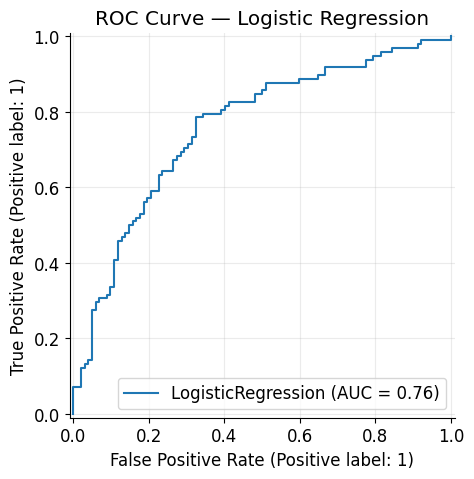

In [ ]:
from sklearn.metrics import RocCurveDisplay

# ROC Curve for Logistic Regression
RocCurveDisplay.from_estimator(model, X_test_proc, y_test)
plt.title("ROC Curve — Logistic Regression")
plt.show()

# --- Interpretation ---
# The ROC curve shows the trade-off between True Positive Rate (sensitivity)
# and False Positive Rate (1-specificity) across thresholds.
# The further the curve bows toward the top-left, the better.

In [ ]:
# KNN Experiment
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_proc, y_train)

y_pred_knn = knn.predict(X_test_proc)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN Accuracy: 0.63


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Grid for KNN
param_grid = {
    "n_neighbors": [3, 5, 9, 15, 25],
    "weights": ["uniform", "distance"]
}

# GridSearchCV using accuracy as metric
gs_acc = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,                # 5-fold cross-validation
    scoring="accuracy",  # ✅ now use accuracy instead of roc_auc
    n_jobs=-1,
    verbose=1
)

gs_acc.fit(X_train_proc, y_train)

print("Best params (accuracy):", gs_acc.best_params_)
print("Best CV accuracy:", gs_acc.best_score_)

# Evaluate on test data
y_pred_knn = gs_acc.predict(X_test_proc)
print("Test accuracy:", accuracy_score(y_test, y_pred_knn))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params (accuracy): {'n_neighbors': 15, 'weights': 'uniform'}
Best CV accuracy: 0.6849999999999999
Test accuracy: 0.695


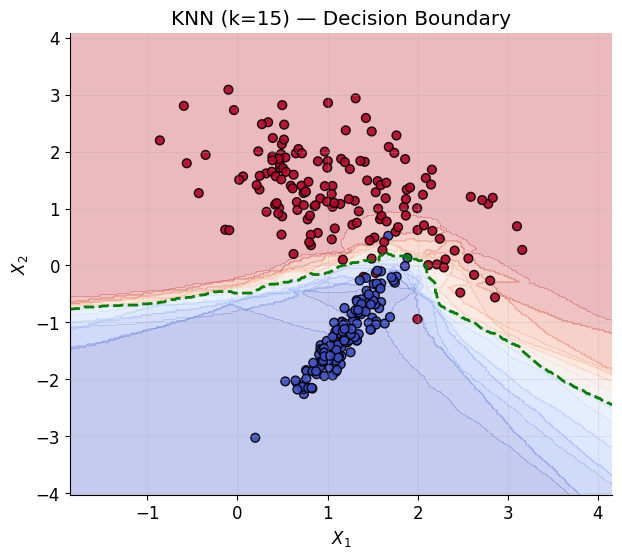

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Use the same toy 2D dataset from before
knn_vis = KNeighborsClassifier(n_neighbors=15)
knn_vis.fit(X_vis, y_vis)

# Create grid
xx, yy = np.meshgrid(
    np.linspace(X_vis[:,0].min()-1, X_vis[:,0].max()+1, 300),
    np.linspace(X_vis[:,1].min()-1, X_vis[:,1].max()+1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
probs_knn = knn_vis.predict_proba(grid)[:, 1].reshape(xx.shape)

# Plot KNN boundary
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, probs_knn, levels=25, alpha=0.3, cmap="coolwarm")
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_vis, cmap="coolwarm", edgecolor="k", s=40, alpha=0.9)

# Decision boundary at probability=0.5
plt.contour(xx, yy, probs_knn, levels=[0.5], colors="green", linestyles="--", linewidths=2)

plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("KNN (k=15) — Decision Boundary")
plt.show()

# --- Interpretation Guide ---
# Compare this to logistic regression's smooth linear boundary.
# KNN boundaries are more flexible and can curve around the data.
# Larger k = smoother boundary, smaller k = more jagged.

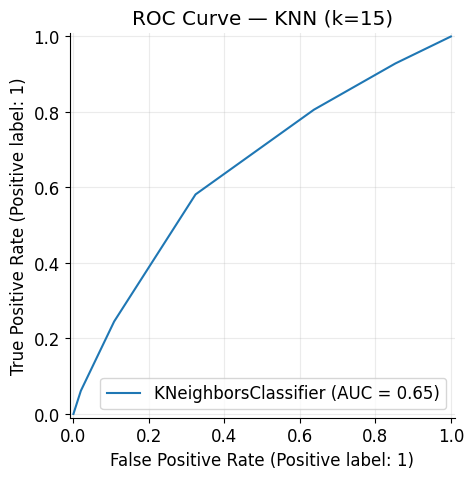

In [ ]:
# ROC Curve for KNN (using the best K from grid search or a chosen value, e.g., 15)
RocCurveDisplay.from_estimator(knn, X_test_proc, y_test)
plt.title("ROC Curve — KNN (k=15)")
plt.show()

# --- Interpretation ---
# KNN probability outputs are based on neighbor votes.

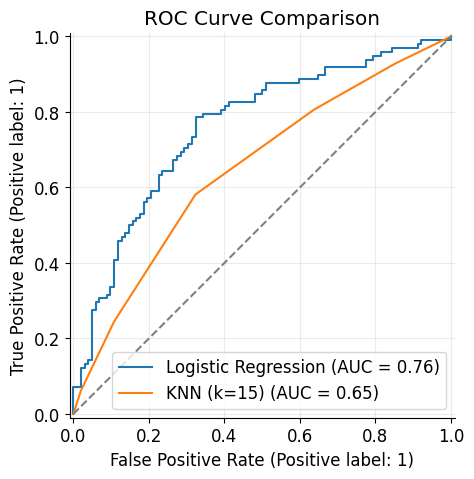

In [ ]:
# Compare both models on one ROC curve
fig, ax = plt.subplots(figsize=(6,5))

RocCurveDisplay.from_estimator(model, X_test_proc, y_test, ax=ax, name="Logistic Regression")
RocCurveDisplay.from_estimator(knn, X_test_proc, y_test, ax=ax, name="KNN (k=15)")

plt.plot([0,1],[0,1],"--",color="grey")  # reference diagonal
plt.title("ROC Curve Comparison")
plt.show()

# --- Interpretation ---
# Both curves on one plot allow direct comparison of performance.
# The model with the higher curve and larger AUC is generally better.

In [ ]:
# answer
# model.fit(X_train_proc, y_train)

# 🌳 Decision Tree Classifier

**Goals**
1) Fit a Decision Tree
2) See how trees split data (visualize a real tree).
3) Compare performance and interpret **feature importance**.
4) Understand **overfitting vs underfitting** via `max_depth`.

We’ll use:
- A **2D toy dataset** to *visualize the decision boundary*.
- A **synthetic building dataset** (Overheating Yes/No) to fit, evaluate, and interpret.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({
    "figure.figsize": (6.5, 5),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 12,
})
np.random.seed(42)

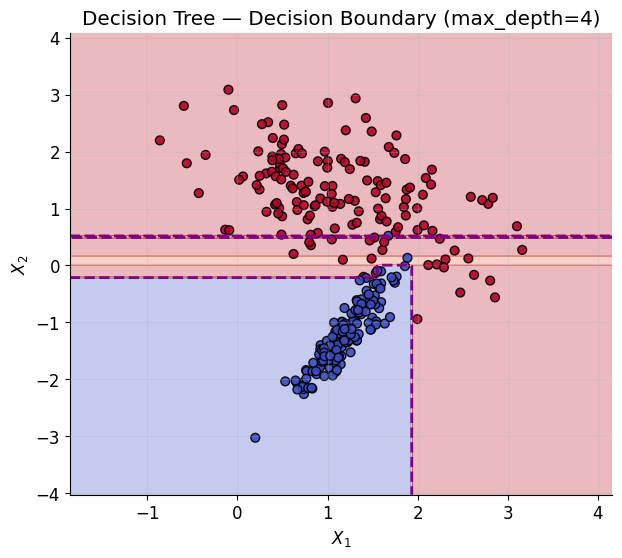

In [ ]:
from sklearn.datasets import make_classification

# 2D toy dataset (for visualization only)
X_vis, y_vis = make_classification(
    n_samples=300, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, class_sep=1.2, random_state=42
)

# Fit a decision tree (tweak depth to see boundary change)
tree_vis = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_vis.fit(X_vis, y_vis)

# Grid to plot decision regions
xx, yy = np.meshgrid(
    np.linspace(X_vis[:,0].min()-1, X_vis[:,0].max()+1, 300),
    np.linspace(X_vis[:,1].min()-1, X_vis[:,1].max()+1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
probs = tree_vis.predict_proba(grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, probs, levels=25, alpha=0.3, cmap="coolwarm")
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_vis, cmap="coolwarm", edgecolor="k", s=40, alpha=0.9)
plt.contour(xx, yy, probs, levels=[0.5], colors="purple", linestyles="--", linewidths=2)
plt.title("Decision Tree — Decision Boundary (max_depth=4)")
plt.xlabel("$X_1$"); plt.ylabel("$X_2$")
plt.show()

In [ ]:
# Synthetic building dataset (same structure as before)
n = 800
rng = np.random.default_rng(42)

X_df = pd.DataFrame({
    "WWR": rng.uniform(10, 80, n),                     # Window-to-Wall Ratio (%)
    "SHGC": rng.uniform(0.2, 0.6, n),                  # Glazing Solar Heat Gain Coef
    "Orientation": rng.choice(["N","E","S","W"], n),   # Primary facade orientation
    "FloorArea": rng.uniform(200, 5000, n),            # m²
    "OccDensity": rng.uniform(0.05, 0.3, n),           # people per m²
    "OutdoorTemp": rng.normal(30, 4, n),               # °C
    "ShadingDepth": rng.uniform(0.0, 1.5, n),          # m
})

z = (
    + 0.05*(X_df["WWR"] - 45)
    + 2.0*(X_df["SHGC"] - 0.35)
    + 0.03*(X_df["OutdoorTemp"] - 30)
    + 2.5*(X_df["OccDensity"] - 0.15)
    - 0.6*(X_df["ShadingDepth"] - 0.5)
    + X_df["Orientation"].map({"N":-0.15, "E":0.1, "S":0.2, "W":0.0}).values
)
prob = 1 / (1 + np.exp(-z))
y = (rng.random(n) < prob).astype(int)

data = X_df.copy()
data["Overheating"] = y

display(data.head())
print("Overheating rate:", data["Overheating"].mean().round(3))


,WWR,SHGC,Orientation,FloorArea,OccDensity,OutdoorTemp,ShadingDepth,Overheating
0,64.176923,0.495432,W,4245.113450,0.299557,31.785844,0.457433,1
1,40.721491,0.326861,W,2342.669562,0.173116,29.759631,0.270467,0
2,70.101854,0.556008,W,4774.280775,0.065326,30.050314,0.920391,1
3,58.815762,0.437532,N,3323.814031,0.198964,32.627274,0.342655,1
4,16.592414,0.250411,E,756.314554,0.079756,27.090529,0.888311,0


Overheating rate: 0.489


In [ ]:
# Split
X = data.drop(columns=["Overheating"])
y = data["Overheating"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Trees do NOT need scaling; just one-hot encode Orientation
X_train_proc = pd.concat([
    X_train.drop(columns=["Orientation"]),
    pd.get_dummies(X_train["Orientation"], prefix="Orient")
], axis=1)

X_test_proc = pd.concat([
    X_test.drop(columns=["Orientation"]),
    pd.get_dummies(X_test["Orientation"], prefix="Orient")
], axis=1)

# Align columns
X_test_proc = X_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)

X_train_proc.head()

,WWR,SHGC,FloorArea,OccDensity,OutdoorTemp,ShadingDepth,Orient_E,Orient_N,Orient_S,Orient_W
562,69.051187,0.447486,3784.312231,0.196287,28.417426,0.466110,False,False,True,False
459,54.548584,0.598671,2731.518947,0.060744,31.184402,0.545202,True,False,False,False
664,33.934886,0.461277,2559.729605,0.237831,34.818030,1.399613,False,False,True,False
682,11.236815,0.437183,936.762586,0.259581,21.836565,0.034200,False,False,True,False
786,66.921154,0.337856,3496.877916,0.147612,27.110559,0.078133,True,False,False,False


In [ ]:
# Create the model (tune max_depth to control complexity)
model = DecisionTreeClassifier(max_depth=5, random_state=42)

# 👉 STUDENTS: fill this line to train the model
# 👉## FILL ME ##👈

# Uncomment after filling:
print("Tree depth:", model.get_depth(), "| Leaves:", model.get_n_leaves())

Tree depth: 5 | Leaves: 26


Accuracy: 0.64
ROC AUC: 0.641906762705082

Classification report:
               precision    recall  f1-score   support

           0      0.644     0.657     0.650       102
           1      0.635     0.622     0.629        98

    accuracy                          0.640       200
   macro avg      0.640     0.640     0.640       200
weighted avg      0.640     0.640     0.640       200



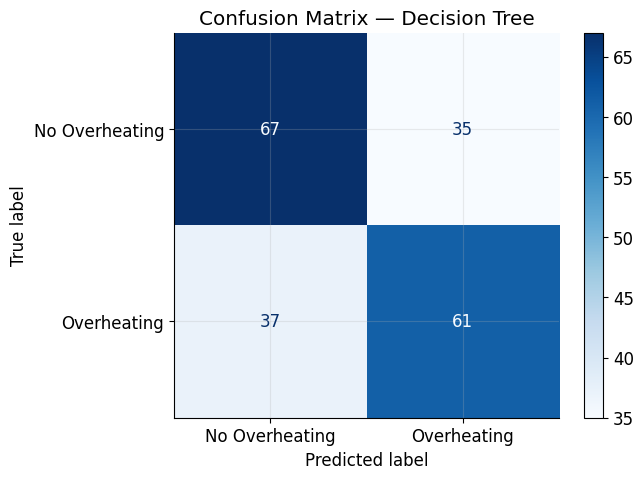

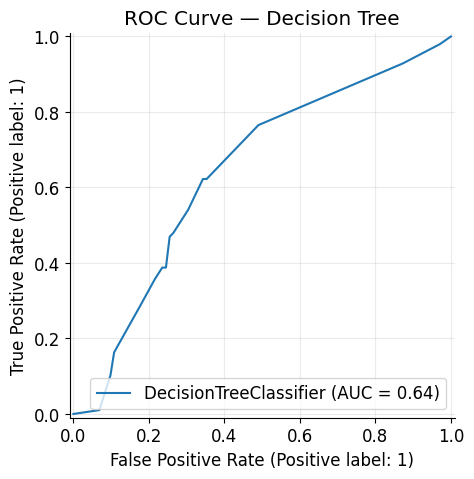

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = model.predict(X_test_proc)
y_prob = model.predict_proba(X_test_proc)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob).round(3))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

# Confusion Matrix (lighter cmap so text is readable)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["No Overheating","Overheating"],
    cmap="Blues", ax=ax, colorbar=True
)
plt.title("Confusion Matrix — Decision Tree")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(model, X_test_proc, y_test)
plt.title("ROC Curve — Decision Tree")
plt.show()

# --- Interpretation guide (talk track in class) ---
# CM: TL=TN, TR=FP, BL=FN, BR=TP. ROC: closer to top-left & higher AUC = better.

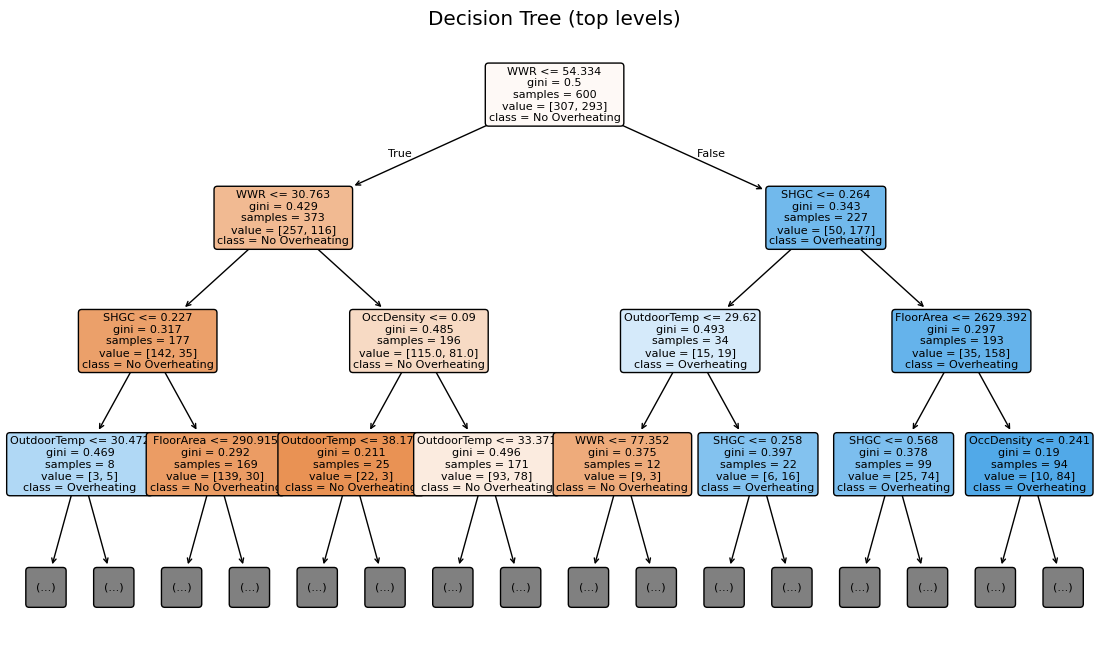

In [ ]:
from sklearn import tree

plt.figure(figsize=(14, 8))
plot_tree(
    model,
    feature_names=X_train_proc.columns,
    class_names=["No Overheating","Overheating"],
    filled=True, rounded=True, fontsize=8, max_depth=3  # show top levels for readability
)
plt.title("Decision Tree (top levels)")
plt.show()

# Note: max_depth here only affects visualization (plotting), not the trained model.
# Increase 'max_depth' to see more levels (may become busy).

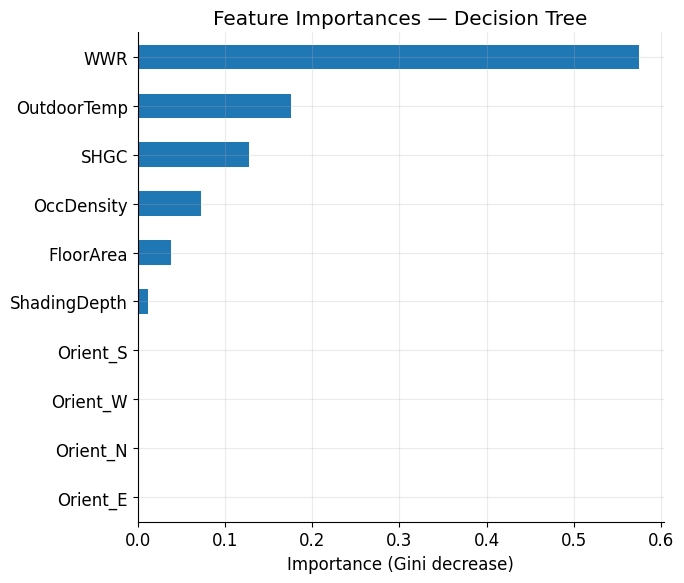

In [ ]:
importances = pd.Series(model.feature_importances_, index=X_train_proc.columns)
imp_sorted = importances.sort_values(ascending=True)

plt.figure(figsize=(7,6))
imp_sorted.plot(kind="barh")
plt.xlabel("Importance (Gini decrease)")
plt.title("Feature Importances — Decision Tree")
plt.tight_layout()
plt.show()

# note: trees capture non-linearities & interactions, but importances are heuristic.

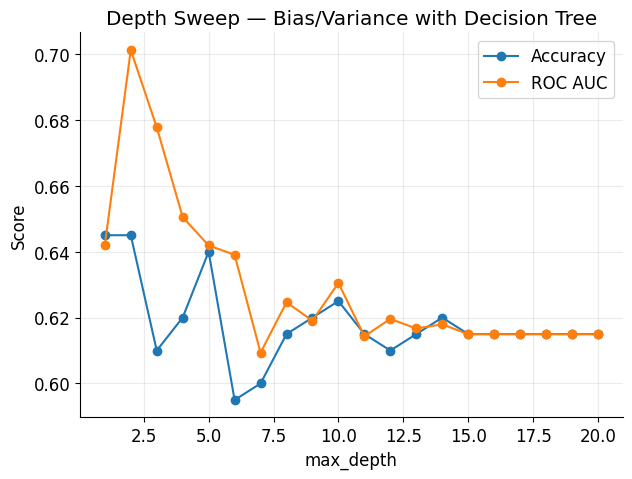

In [ ]:
depths = range(1, 21)
accs, aucs = [], []

for d in depths:
    m = DecisionTreeClassifier(max_depth=d, random_state=42)
    m.fit(X_train_proc, y_train)
    y_hat = m.predict(X_test_proc)
    y_pr = m.predict_proba(X_test_proc)[:, 1]
    accs.append(accuracy_score(y_test, y_hat))
    aucs.append(roc_auc_score(y_test, y_pr))

plt.figure(figsize=(7,5))
plt.plot(depths, accs, marker="o", label="Accuracy")
plt.plot(depths, aucs, marker="o", label="ROC AUC")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.title("Depth Sweep — Bias/Variance with Decision Tree")
plt.legend()
plt.show()

# Talk track: low depth = high bias; very high depth = overfit (variance).
# Choose a depth near the generalization sweet spot.

In [ ]:
param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_leaf": [1, 3, 5, 10]
}
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)
gs.fit(X_train_proc, y_train)

print("Best params:", gs.best_params_)
print("Best CV ROC AUC:", gs.best_score_)
best_tree = gs.best_estimator_

# Test performance of best model
y_prob_best = best_tree.predict_proba(X_test_proc)[:, 1]
print("Test ROC AUC (best):", roc_auc_score(y_test, y_prob_best).round(3))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'max_depth': 3, 'min_samples_leaf': 3}
Best CV ROC AUC: 0.7242504329314069
Test ROC AUC (best): 0.678


In [ ]:
# answer
# model.fit(X_train_proc, y_train)